             Open   High    Low  Close    Volume    Change
Date                                                      
1997-07-19   1215   1224   1197   1224     17360       NaN
1997-07-21   1222   1250   1211   1230     37770  0.004902
1997-07-22   1224   1242   1211   1233     64750  0.002439
1997-07-23   1233   1250   1224   1224     56070 -0.007299
1997-07-24   1215   1233   1215   1233     53570  0.007353
...           ...    ...    ...    ...       ...       ...
2021-07-22  79000  79800  78900  79700  12618790  0.015287
2021-07-23  79700  79900  79200  79300   9098910 -0.005019
2021-07-26  79400  79500  78800  78800  10040975 -0.006305
2021-07-27  79200  79400  78500  78500  11427693 -0.003807
2021-07-28  78300  78900  78100  78600   3797770  0.001274

[6000 rows x 6 columns]


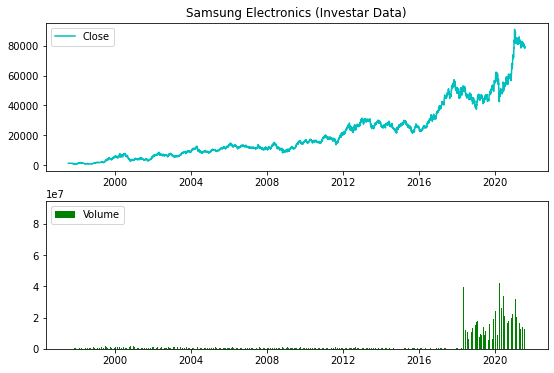

In [1]:
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import mplfinance as mpf
import matplotlib.dates as mdates
df = fdr.DataReader('005930')
print(df)

plt.figure(figsize=(9, 6))
plt.subplot(2, 1, 1)
plt.title('Samsung Electronics (Investar Data)')
plt.plot(df.index, df['Close'], 'c', label='Close')
plt.legend(loc='best')
plt.subplot(2, 1, 2)
plt.bar(df.index, df['Volume'], color='g', label='Volume')
plt.legend(loc='best')
plt.show()

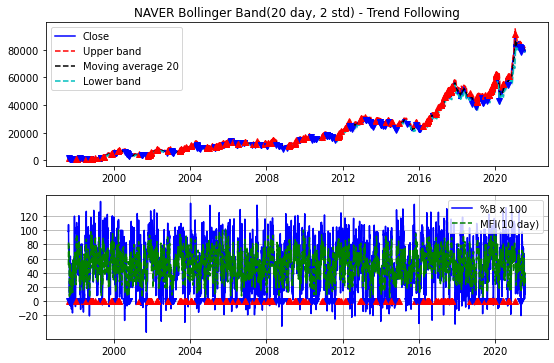

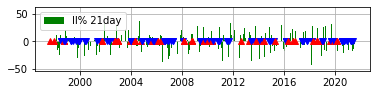

In [2]:
# 볼린저밴드 추세 추종 매매 기법
df['MA20'] = df['Close'].rolling(window=20).mean() 
df['stddev'] = df['Close'].rolling(window=20).std() 
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3 # 중심가격 구하기
df['PMF'] = 0
df['NMF'] = 0

# MFI
for i in range(len(df.Close)-1):
    if df.TP.values[i] < df.TP.values[i+1]: 
        df.PMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1] # 긍정적 현금흐름에 저장
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.Volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
df['MFI10'] = 100 - 100 / (1 + df['MFR'])
df = df[19:]

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('NAVER Bollinger Band(20 day, 2 std) - Trend Following')
plt.plot(df.index, df['Close'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')

# 추세 추종 매매
for i in range(len(df.Close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:       # ①
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')  # 빨간색 삼각형 표시
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:     # ③
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')  # 파란색 삼각형 표시
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['PB'] * 100, 'b', label='%B x 100')       # MFI와 비교할 수 있게 %b를 100곱해서 푸른 실선으로
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)')     # 10일 기준 MFI를 녹색 점선으로
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])                  # ⑦
for i in range(len(df.Close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()


# 반전 매매 기법
df['II'] = (2*df['Close']-df['High']-df['Low'])/(df['High']-df['Low'])*df['Volume']
df['IIP21'] = df['II'].rolling(window=21).sum()/df['Volume'].rolling(window=21).sum()*100
df = df.dropna()

plt.subplot(3, 1, 3)

plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')

for i in range(len(df.Close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:       
        plt.plot(df.index.values[i], 0, 'r^')  
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:     
        plt.plot(df.index.values[i], 0, 'bv')  

plt.grid(True)
plt.legend(loc='best')
plt.show()


# RNN 사용

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt

window_size = 20 
data_size = 5

raw_df = fdr.DataReader('005930')

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

dfx = raw_df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

## 훈련, 테스트 데이터셋 분리

In [4]:

data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)
print(_x, "->", _y)

# 훈련용 데이터셋 70%
train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])
# 테스트용 데이터셋 30%
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])


[[0.8981173864884849, 0.8409090909082222, 0.9016759776526239, 0.14715098613907646, 0.8860279065640335], [0.891472868216067, 0.8326446280983134, 0.8938547486023533, 0.14819453601717616, 0.8793887554901582], [0.8859357696557187, 0.8305785123958361, 0.8927374301666002, 0.09692689128009471, 0.8782822303111789], [0.8870431893677885, 0.8347107438007906, 0.8938547486023533, 0.0922524823523422, 0.8827083310270958], [0.8925802879281367, 0.838842975205745, 0.8994413407811179, 0.1343391050647619, 0.8915605324589296], [0.8992248062005546, 0.8398760330569836, 0.8972067039096121, 0.1770886835349035, 0.8871344317430127], [0.8981173864884849, 0.838842975205745, 0.8927374301666002, 0.18449455567142412, 0.8771757051321997], [0.8815060908074401, 0.8243801652884045, 0.8826815642448238, 0.2515949379631027, 0.8716430792373036], [0.8848283499436491, 0.8264462809908818, 0.8882681564235885, 0.10816655432108468, 0.8749626547742413], [0.8859357696557187, 0.828512396693359, 0.8916201117308473, 0.10922231820310574

## 모델 생성

In [5]:
model = Sequential()
model.add(LSTM(units=window_size, activation='relu', return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(LSTM(units=window_size, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=60, batch_size=30) #, verbose=0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 20)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 20, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 5,381
Trainable params: 5,381
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
160/160 [==============================] - 4s 13ms/step - loss: 0.0099
Epoch 2/60
160/160 [==================

In [6]:
pred_y = model.predict(test_x)
print("정확도", model.evaluate(test_x,  test_y, verbose=2))
# print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

38/38 - 2s - loss: 0.0166
정확도 0.016628900542855263


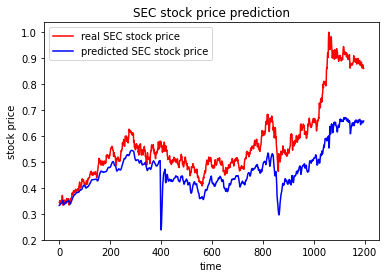

Tomorrow's SEC price : [59892.0967618] KRW


In [7]:

# Visualising the results
plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Tomorrow's SEC price :", raw_df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

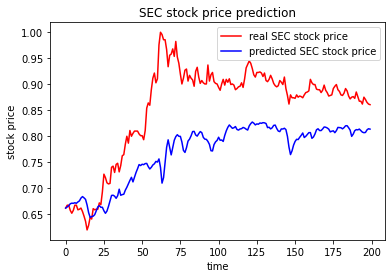

Today's SEC price : 78400 KRW
Tomorrow's SEC price : [59892.0967618] KRW


In [8]:
# Visualising the results
pred = pred_y + (test_y[-200] - pred_y[-200])
plt.figure()
plt.plot(test_y[-200:], color='red', label='real SEC stock price')
plt.plot(pred[-200:], color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Today's SEC price :", raw_df.Close[-1], 'KRW')
print("Tomorrow's SEC price :", raw_df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

In [9]:
raw_df.index

DatetimeIndex(['1997-07-18', '1997-07-19', '1997-07-21', '1997-07-22',
               '1997-07-23', '1997-07-24', '1997-07-25', '1997-07-26',
               '1997-07-28', '1997-07-29',
               ...
               '2021-07-14', '2021-07-15', '2021-07-16', '2021-07-19',
               '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23',
               '2021-07-26', '2021-07-27'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [10]:
print(len(pred_y))
print(test_x)

1794
[[[0.28660022 0.27128099 0.28826816 0.0026023  0.27854558]
  [0.28128461 0.26549587 0.28379888 0.00240001 0.27522601]
  [0.28239203 0.26363636 0.28111732 0.00195335 0.27323426]
  ...
  [0.30941307 0.28863636 0.30703911 0.00238339 0.30222522]
  [0.30719823 0.28904959 0.30726257 0.00234939 0.30156131]
  [0.30874862 0.28822314 0.30480447 0.00355714 0.29647129]]

 [[0.28128461 0.26549587 0.28379888 0.00240001 0.27522601]
  [0.28239203 0.26363636 0.28111732 0.00195335 0.27323426]
  [0.28128461 0.26508264 0.28290503 0.00244626 0.27588992]
  ...
  [0.30719823 0.28904959 0.30726257 0.00234939 0.30156131]
  [0.30874862 0.28822314 0.30480447 0.00355714 0.29647129]
  [0.30321152 0.28512397 0.30389944 0.00221451 0.29846304]]

 [[0.28239203 0.26363636 0.28111732 0.00195335 0.27323426]
  [0.28128461 0.26508264 0.28290503 0.00244626 0.27588992]
  [0.28349945 0.26549587 0.28335196 0.0016917  0.27389818]
  ...
  [0.30874862 0.28822314 0.30480447 0.00355714 0.29647129]
  [0.30321152 0.28512397 0.30

# ARIMA 사용

In [6]:
!pip install pmdarima

You should consider upgrading via the 'c:\users\bangh\documents\인공지능 국비교육\프로젝트\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import datetime

In [58]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt

window_size = 20 
data_size = 5

raw_df = fdr.DataReader('005930')

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

dfx = raw_df[['Open','High','Low','Volume', 'Close']]
train_x = raw_df[['Close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

In [75]:
# model = ARIMA(dfx, order=(0,1,1))
model_arima= auto_arima(train_x,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)

model_arima.fit(train_x)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90880.649, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=90878.735, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=90878.781, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=90871.665, Time=0.62 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=90872.873, Time=0.66 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=90869.561, Time=0.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=90878.880, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=90880.338, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=90877.725, Time=2.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=90872.840, Time=1.60 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=90874.301, Time=2.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=90878.411, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=90877.172, Time=1.68 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=90846.266, Time=4.07 sec
 

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

In [76]:
print(model_arima.order)
print(model_arima.summary())

(2, 1, 3)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6000
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -45416.133
Date:                Wed, 28 Jul 2021   AIC                          90846.266
Time:                        11:15:10   BIC                          90893.162
Sample:                             0   HQIC                         90862.552
                               - 6000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.2387      3.746      3.534      0.000       5.896      20.581
ar.L1          1.2926      0.017     75.924      0.000       1.259       1.326
ar.L2         -0.9027      0.016    -55.96

In [77]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_x, order=model_arima.order)

model_fit = model.fit(disp=0)

print(model_fit.summary())
print(type(model_fit))

c:\users\bangh\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\bangh\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date i

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5999
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -45429.373
Method:                       css-mle   S.D. of innovations            470.542
Date:                Wed, 28 Jul 2021   AIC                          90872.747
Time:                        11:15:11   BIC                          90919.642
Sample:                             1   HQIC                         90889.032
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8657      5.647      2.278      0.023       1.797      23.934
ar.L1.D.Close     0.2070      0.376      0.551      0.582      -0.529       0.943
ar.L2.D.Close     0.1843      0.259     

c:\users\bangh\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


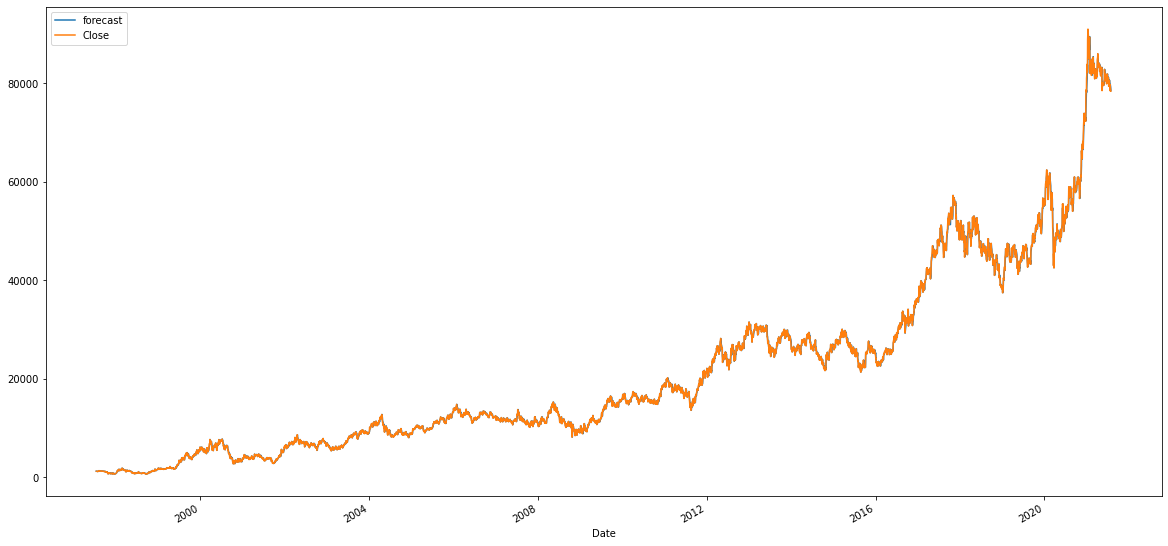

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
model_fit.plot_predict(dynamic=False, ax= ax)
# plt.figure(figsize=(20,10), dpi=100)
plt.savefig('predict_vs_real.png')
# plt.show()

c:\users\bangh\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\bangh\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date i

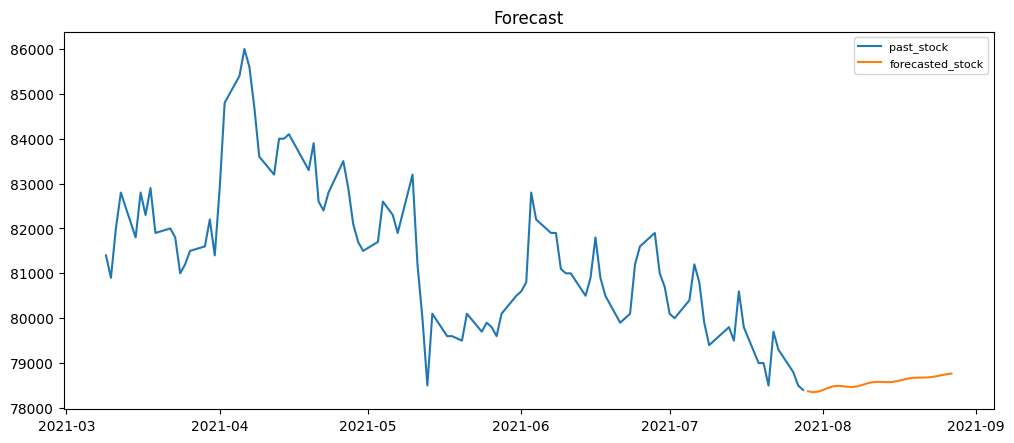

In [80]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

model = ARIMA(train_x, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(30, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=[(train_x.index[-1] + datetime.timedelta(days=x)) for x in range(1, 31)])

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_x[-100:], label='past_stock')
plt.plot(fc_series, label='forecasted_stock')
plt.title('Forecast')
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [81]:
fc_series

2021-07-29    78371.616232
2021-07-30    78353.179045
2021-07-31    78362.295551
2021-08-01    78398.444590
2021-08-02    78445.094532
2021-08-03    78481.123098
2021-08-04    78493.825880
2021-08-05    78485.625560
2021-08-06    78471.123589
2021-08-07    78467.209429
2021-08-08    78482.796803
2021-08-09    78514.322759
2021-08-10    78549.109175
2021-08-11    78573.805128
2021-08-12    78582.386977
2021-08-13    78579.006721
2021-08-14    78574.509993
2021-08-15    78579.324069
2021-08-16    78597.303813
2021-08-17    78624.096697
2021-08-18    78650.547642
2021-08-19    78668.617881
2021-08-20    78676.050173
2021-08-21    78677.133373
2021-08-22    78679.501128
2021-08-23    78689.262427
2021-08-24    78707.523775
2021-08-25    78730.230672
2021-08-26    78751.091516
2021-08-27    78765.539145
dtype: float64